In [1]:
from google.colab import files  # Import the "files" module from the "google.colab" library

files.upload()  # Choose the kaggle.json file for your device


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahafosama","key":"c01c5bd5c9c7f141d7674b96edb3eb84"}'}

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 99% 344M/346M [00:09<00:00, 42.5MB/s]
100% 346M/346M [00:09<00:00, 36.5MB/s]


In [3]:
import zipfile
with zipfile.ZipFile("intel-image-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("intel-image-classification")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
import cv2
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [5]:
trainpath = 'intel-image-classification/seg_train/'

for folder in  os.listdir(trainpath + 'seg_train') :
    files = gb.glob(pathname= str( trainpath +'seg_train//' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')

For training data , found 2271 in folder forest
For training data , found 2191 in folder buildings
For training data , found 2382 in folder street
For training data , found 2404 in folder glacier
For training data , found 2274 in folder sea
For training data , found 2512 in folder mountain


In [12]:
testpath = 'intel-image-classification/seg_test/'

for folder in  os.listdir(testpath +'seg_test') :
    files = gb.glob(pathname= str( testpath +'seg_test//' + folder + '/*.jpg'))
    print(f'For testing data , found {len(files)} in folder {folder}')

For testing data , found 474 in folder forest
For testing data , found 437 in folder buildings
For testing data , found 501 in folder street
For testing data , found 553 in folder glacier
For testing data , found 510 in folder sea
For testing data , found 525 in folder mountain


In [6]:
predpath = 'intel-image-classification/seg_pred/'

files = gb.glob(pathname= str(predpath +'seg_pred/*.jpg'))
print(f'For Prediction data , found {len(files)}')

For Prediction data , found 7301


In [7]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def getcode(n) :
    for x , y in code.items() :
        if n == y :
            return x

In [9]:
s = 100
X_train = []
y_train = []
for folder in  os.listdir(trainpath +'seg_train') :
    files = gb.glob(pathname= str( trainpath +'seg_train//' + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image_array = cv2.resize(image , (s,s))
        X_train.append(list(image_array))
        y_train.append(code[folder])

In [10]:
print(f'we have {len(X_train)} items in X_train')


we have 14034 items in X_train


In [13]:
s = 100
X_test = []
y_test = []
for folder in  os.listdir(testpath +'seg_test') :
    files = gb.glob(pathname= str(testpath + 'seg_test//' + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image_array = cv2.resize(image , (s,s))
        X_test.append(list(image_array))
        y_test.append(code[folder])

In [14]:
 print(f'we have {len(X_test)} items in X_test')

we have 3000 items in X_test


In [15]:
s = 100
X_pred = []
files = gb.glob(pathname= str(predpath + 'seg_pred/*.jpg'))
for file in files:
    image = cv2.imread(file)
    image_array = cv2.resize(image , (s,s))
    X_pred.append(list(image_array))

In [16]:
    print(f'we have {len(X_pred)} items in X_pred')


we have 7301 items in X_pred


In [17]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_pred_array = np.array(X_pred)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


data_gen.fit(X_train)

KerasModel = keras.models.Sequential([
    layers.Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(s,s,3)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    layers.Flatten(),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])
# Compile the model
KerasModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print('Model Details are : ')
print(KerasModel.summary())

# تغيير طريقة التدريب لاستخدام المولد
history = KerasModel.fit(
    data_gen.flow(X_train, y_train, batch_size=32),  # استخدام المولد للبيانات
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping]
)

ModelLoss, ModelAccuracy = KerasModel.evaluate(X_test, y_test)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

Model Details are : 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 98, 98, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 96, 96, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 46, 46, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 44, 44, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 20, 20, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 698,726 (2.67 MB)

 Trainable params: 698,726 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 168ms/step - accuracy: 0.1712 - loss: 7.3984 - val_accuracy: 0.1607 - val_loss: 3.7982
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - accuracy: 0.1799 - loss: 3.5874 - val_accuracy: 0.1607 - val_loss: 3.0433
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 130ms/step - accuracy: 0.1962 - loss: 2.8936 - val_accuracy: 0.1607 - val_loss: 2.5725
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 126ms/step - accuracy: 0.1735 - loss: 2.4803 - val_accuracy: 0.1607 - val_loss: 2.2832
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 44s 124ms/step - accuracy: 0.1864 - loss: 2.2277 - val_accuracy: 0.1607 - val_loss: 2.0924
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 120ms/step - accuracy: 0.1997 - loss: 2.0491 - val_accuracy: 0.1607 - val_loss: 1.9976
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 43s 120ms/step - accuracy: 0.2385 - loss: 1.9071 - val_accuracy: 0.2526 - val_loss: 1.8133
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 126ms/step - accuracy: 0.4072 - loss: 1.622

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


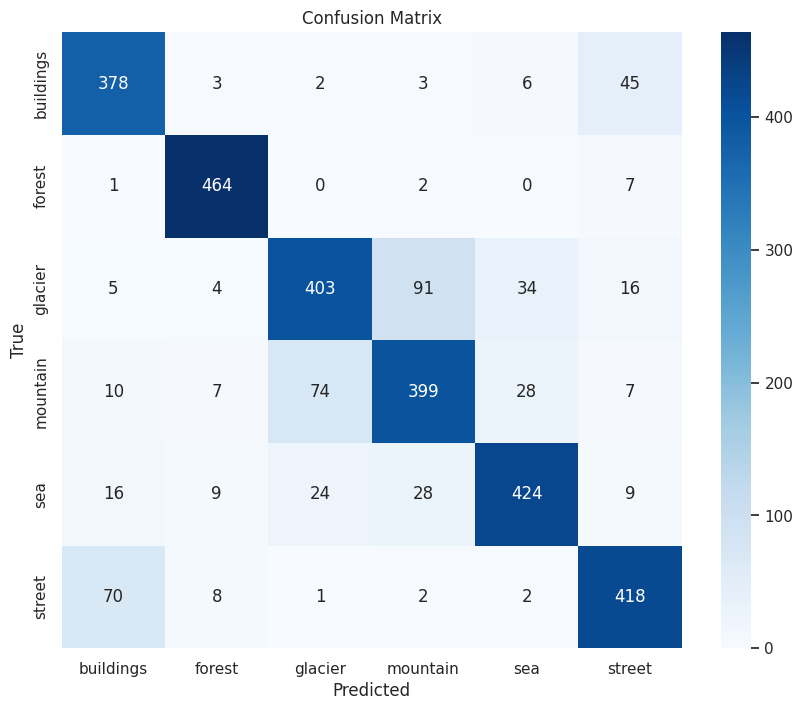

              precision    recall  f1-score   support

   buildings       0.79      0.86      0.82       437
      forest       0.94      0.98      0.96       474
     glacier       0.80      0.73      0.76       553
    mountain       0.76      0.76      0.76       525
         sea       0.86      0.83      0.84       510
      street       0.83      0.83      0.83       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



In [21]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


predictions = KerasModel.predict(X_test)
predicted_classes = predictions.argmax(axis=1)


class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

cm = confusion_matrix(y_test, predicted_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print(classification_report(y_test, predicted_classes, target_names=class_names))